## STEP 2 - Loan Grade Prediction

In this second step, a machine learning model will be created to predict loan grades (ranging from A to G) from Lending Club's database. This model aims to provide critical insights into borrower creditworthiness, enabling investors and lenders to make informed decisions while reducing risk.

A Lending Club loan grade prediction model can be extremely useful and helpful for Lending Club as a company in several ways:

**1. Risk assessment**: Accurately predicting loan grades can help Lending Club to better assess the risk associated with each loan application, thereby allowing them to make more informed lending decisions, mitigate potential losses, and efficiently allocate their resources.

**2. Pricing**: With a better understanding of each borrower's creditworthiness, Lending Club can set interest rates and loan terms that are more reflective of the potential risk involved, and thus, offer competitive pricing that attracts borrowers while maintaining profitability for investors.

**3. Faster decision-making**: An accurate prediction model can automate the loan grade assignment process, reducing the time spent on manual review and making the loan application process more efficient for both borrowers and lenders.

**4. Enhanced borrower experience**: By quickly and accurately assigning loan grades, Lending Club can provide more personalized loan offers to borrowers, leading to an improved customer experience and higher satisfaction levels.

**5. Attracting investors**: By demonstrating a robust and accurate loan grade prediction model, Lending Club can attract more investors to the platform, providing them with confidence in the company's ability to manage risk and generate positive returns on their investments.

**6. Portfolio diversification**: Accurate loan grade predictions can help Lending Club and its investors diversify their loan portfolios, resulting in a well-balanced mix of low and high-risk loans, which can help to maintain overall stability and minimize losses during economic downturns.

**7. Compliance and transparency**: A data-driven loan grading model can provide transparency into the decision-making process, enabling Lending Club to meet regulatory requirements and build trust with both borrowers and investors.

In summary, a Lending Club loan grade prediction model can lead to better risk management, improved pricing, increased efficiency, enhanced borrower experiences, and higher levels of trust with investors, ultimately driving business growth and long-term success for the company.

#### Imports

In [9]:
import numpy as np
import pandas as pd
import helpers  
import warnings
import pickle
import lightgbm as lgb
  
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [10]:
warnings.filterwarnings('ignore')

## Reading the data

First, I start with reading the initial dataset, because this time only accepted dataset will be examined and more its columns.

In [11]:
''' Reading Dataset '''
df_accepted = pd.read_csv("lending-club/accepted.csv")

In [12]:
''' Dropping rows where 'grade' is missing '''
df_accepted = df_accepted[df_accepted.grade.isnull() == False]

In [13]:
cols_to_remove = helpers.get_cols_with_large_missing_vals(df_accepted)

In [14]:
cols_to_remove = list(cols_to_remove.keys())
cols_to_remove.append("id")

In [8]:
df_accepted = df_accepted.drop(cols_to_remove, axis=1)

In [9]:
more_useless_cols = ['url', 'pymnt_plan', 'title', 'zip_code',
                     'last_pymnt_d', 'debt_settlement_flag',
                     'issue_d', 'last_credit_pull_d', 'earliest_cr_line',
                     'sec_app_earliest_cr_line', 'next_pymnt_d']

In [10]:
df_accepted = df_accepted.drop(more_useless_cols, axis=1)

## Data Exploration

### About Loan Grade
The **loan grades** in Lending Club are determined before the loan is accepted by investors. Lending Club uses a proprietary credit model to assign grades to loans based on factors such as credit history, income, employment status, and loan amount. The grades range from A to G, with A being the least risky and G being the most risky. Once a loan is graded, it is made available for investors to fund. The loan grades do not change after the loan is accepted or after the first installment is made.

Target Features:
* **grade**
* **subgrade**
* **int_rate**

Set only afert knowing loan grade (Data Leakage):
* **installment**: refers to the periodic payment you make to repay your loan over time.
* **chargeoff_within_12_mths**, **sec_app_chargeoff_within_12_mths**: this feature may represent data leakage because it reflects the outcome of the loan, which is not known at the time of loan application.
* **delinq_2yrs**, **inq_last_6mths**, **mths_since_last_delinq**, **mths_since_last_record**, **pub_rec**, **pub_rec_bankruptcies** **collections_12_mths_ex_med**, **sec_app_collections_12_mths_ex_med**, **mths_since_last_major_derog**, **sec_app_mths_since_last_major_derog**, **acc_now_delinq**, **delinq_amnt**, **num_accts_ever_120_pd**, **num_tl_30dpd**, **num_tl_90g_dpd_24m**, **sec_app_inq_last_6mths**: These variables relate to the borrower's credit history and may be useful for predicting loan grade, but they could also be considered part of the outcome (default) and therefore cause data leakage. Some of these features may indeed be correlated with the outcome (i.e., whether or not the borrower will default on the loan), but they are not considered part of the outcome itself. Rather, they are additional pieces of information about the borrower that the lender may use to assess their creditworthiness and determine whether to approve the loan and at what interest rate.
* **total_pymnt**, **total_pymnt_inv**, **total_rec_prncp**, **total_rec_int**, **total_rec_late_fee**, **recoveries**, **collection_recovery_fee**: These variables are related to payments made by the borrower after the loan has been issued, and would not be known at the time the loan grade is assigned.
* **last_pymnt_amnt**, **last_credit_pull_d**, **last_fico_range_high**, **last_fico_range_low**: These variables are related to payments made by the borrower after the loan has been issued, and would not be known at the time the loan grade is assigned.
* **funded_amnt** and **funded_amnt_inv**: set only after issuing loan 
* **hardship_flag** indicates whether the borrower has requested a hardship plan due to financial difficulties that affect their ability to make payments on time. This is usually set after the loan is issued and the borrower requests a hardship plan.
* **disbursement_method** specifies how the borrower received the funds from the loan. This is typically set after the loan is approved and the borrower agrees to the terms of the loan, and before the funds are disbursed.
* **loan_status**: This is the current status of the loan, such as "Current", "Fully Paid", "Late (16-30 days)", "Charged Off", etc. This information is not available until after the loan has been issued.
* **out_prncp**: This is the remaining outstanding principal balance on the loan. It is updated as the borrower makes payments on the loan.
* **out_prncp_inv**: This is the remaining outstanding principal balance on the loan that is held by investors. Like out_prncp, it is updated as the borrower makes payments on the loan.
* **mths_since_rcnt_il**, **mths_since_recent_bc**, **mths_since_recent_bc_dlq**, and **mths_since_recent_inq** all measure the number of months since the borrower's most recent installment loan, recent bankcard account, recent bankcard delinquency, and recent inquiry, respectively. These values would not be available at the time of loan grade determination because they require time to accumulate.
* **open_acc_6m**, **open_act_il**, **sec_app_open_act_il**, **open_il_12m**, **open_il_24m**, **total_bal_il**, and **il_util** all depend on the borrower's current credit utilization and account status, which can change over time. These values would not be available at the time of loan grade determination because they could be different at the time of application versus the time of loan grade determination.
* **policy_code**: This feature is always equal to 1 and provides no useful information for predicting loan grade.
* **revol_util** and **sec_app_revol_util**: The revol_util value in the loan data refers to the revolving line utilization rate at the time the loan was issued, so it is included for the new loan. Therefore, it won't be useful to set loan grade.
* **revol_bal_joint**: set at the time the loan is issued. This feature represents the total revolving balance on all accounts at the time the borrower applied for the loan, including both the borrower and any co-borrowers or joint account holders. 


Not useful:
* **emp_title**: credit information of user would be more important than employment title.
* **desc**: This variable contains free-form text entered by the borrower, and may not be useful for predicting loan grade. **Purpose** will be more useful.
* **issue_d**: This variable is the date the loan was issued and would not be useful for predicting loan grade.
* **initial_list_status**: This variable is related to how the loan was listed on Lending Club's platform and may not be useful for predicting loan grade.
* **inq_fi** or **open_rv_12m** may not be very relevant in predicting loan grade or default risk. These features may provide additional information, but they may not be as important as other features in the dataset.
* **application_type**: this feature indicates whether the loan application was made by an individual borrower or a joint application with another person.

In [11]:
drop_cols = ['desc', 'issue_d', 'revol_util',  'sec_app_revol_util', 'initial_list_status', 'installment', 'chargeoff_within_12_mths', 'sec_app_chargeoff_within_12_mths', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'pub_rec', 'pub_rec_bankruptcies', 'collections_12_mths_ex_med', 'sec_app_collections_12_mths_ex_med', 'mths_since_last_major_derog', 'sec_app_mths_since_last_major_derog', 'acc_now_delinq', 'delinq_amnt', 'num_accts_ever_120_pd', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'sec_app_inq_last_6mths', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'addr_state', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'disbursement_method', 'loan_status', 'out_prncp', 'out_prncp_inv', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'open_acc_6m', 'open_act_il', 'sec_app_open_act_il', 'open_il_12m', 'open_il_24m', 'total_bal_il', 'il_util', 'policy_code']

In [12]:
results = df_accepted.isnull().sum() 
for i in range(0, len(results)): 
    if results[i] <= 200:
        col = results.index[i]
        df_accepted = df_accepted.dropna(subset=col) 

In [13]:
targets = ['grade', 'sub_grade', 'int_rate']

In [14]:
feature_cols = [col for col in df_accepted.columns if col not in drop_cols]

In [15]:
df_accepted = df_accepted[feature_cols]

In [16]:
df_individual = df_accepted[(df_accepted['verification_status_joint'].isnull() == True) & 
                            (df_accepted['dti_joint'].isnull() == True) &
                            (df_accepted['sec_app_open_acc'].isnull() == True) &
                            (df_accepted['sec_app_fico_range_low'].isnull() == True) &
                            (df_accepted['sec_app_fico_range_high'].isnull() == True) & 
                            (df_accepted['annual_inc_joint'].isnull() == True)]

In [17]:
df_joint = df_accepted[(df_accepted['verification_status_joint'].isnull() == False) & 
                       (df_accepted['dti_joint'].isnull() == False) &
                       (df_accepted['sec_app_open_acc'].isnull() == False) &
                       (df_accepted['sec_app_fico_range_low'].isnull() == False) &
                       (df_accepted['sec_app_fico_range_high'].isnull() == False) & 
                       (df_accepted['annual_inc_joint'].isnull() == False)]

In [18]:
df_accepted = pd.concat([df_joint, df_individual], ignore_index=True)

In [19]:
df_accepted = helpers.remove_num_outliers(df_accepted, nunique=100000, thres=0.99)

In [20]:
df_test = df_accepted.copy()
df_test = helpers.remove_outliers_col(df_test, "loan_amnt", 0.99)
df_test = helpers.remove_outliers_col(df_test, "annual_inc", 0.99)
df_test = helpers.remove_outliers_col(df_test, "dti", 0.99)
df_test = helpers.remove_outliers_col(df_test, "fico_range_high", 0.99)
df_test = helpers.remove_outliers_col(df_test, "fico_range_low", 0.99)

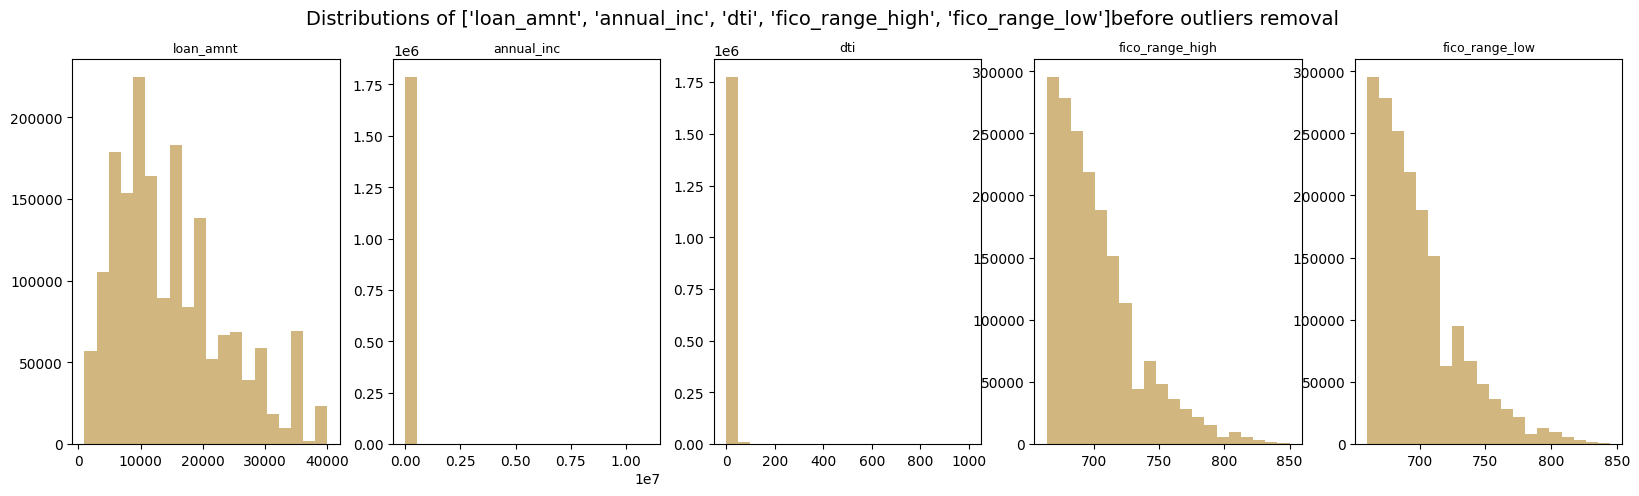

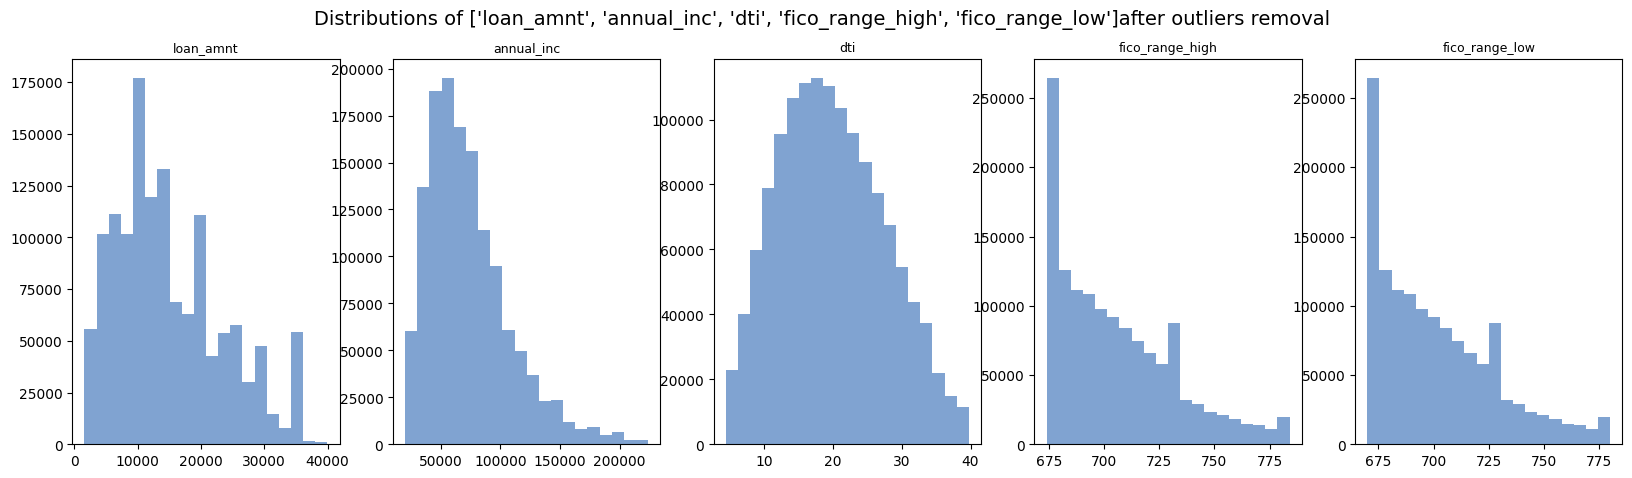

In [21]:
helpers.plot_hist_distributions(df_accepted, ['loan_amnt', 'annual_inc', 'dti', 'fico_range_high', 'fico_range_low'], color="#d1b680", desc="before outliers removal")
helpers.plot_hist_distributions(df_test, ['loan_amnt', 'annual_inc', 'dti', 'fico_range_high', 'fico_range_low'], color="#80a3d1", desc="after outliers removal")

In [22]:
df_accepted = df_test.copy()
df_accepted.grade.value_counts()

B    411338
C    386595
A    271059
D    181850
E     74424
F     22173
G      6183
Name: grade, dtype: int64

In [23]:
cols_clean = [col for col in df_accepted.columns if "sec" not in col and "joint" not in col]

In [24]:
df_accepted.dropna(subset=cols_clean, inplace=True)

## Step 2

In [25]:
df_stratified_sample = helpers.stratified_sample(df_accepted, 'grade')

In [26]:
df_stratified_sample.grade.value_counts()

E    1061
C    1061
B    1061
A    1061
D    1061
F    1061
G    1061
Name: grade, dtype: int64

In [27]:
df_accepted_step2 = df_stratified_sample[feature_cols].copy()
df_accepted_step2 = df_accepted_step2.drop(['emp_title'], axis=1)

In [28]:
for col in df_accepted_step2.columns:
    if "sec" in col or "['joint']" in col:
        if df_accepted_step2[col].dtype != "object":
            print(len(df_accepted_step2[df_accepted_step2[col] == 0]), col)

0 sec_app_fico_range_low
0 sec_app_fico_range_high
158 sec_app_mort_acc
1 sec_app_open_acc
4 sec_app_num_rev_accts


In [29]:
df_accepted_step2[df_accepted_step2['sec_app_fico_range_low'] == 0]

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_mort_acc,sec_app_open_acc,sec_app_num_rev_accts


In [30]:
df_step2_targets = df_accepted_step2[targets] 

In [31]:
encoder = LabelEncoder()
encoder.fit(df_step2_targets['grade'])
df_step2_targets['grade'] = encoder.transform(df_step2_targets['grade'])

In [32]:
feature_cols = [col for col in df_accepted_step2.columns if col not in drop_cols]
df_accepted_step2 = df_accepted_step2[[col for col in feature_cols if col not in targets]]

In [33]:
joint_cols = list( set([col for col in df_accepted_step2.columns if "sec" in col or "joint" in col]))
common_not_joint_cols = [col for col in df_accepted_step2.columns if not ("sec" in col or "joint" in col) and any(col in joint_col for joint_col in joint_cols)]
all_common_cols = joint_cols + common_not_joint_cols

term                     0.183839
loan_amnt                0.121867
bc_open_to_buy           0.052130
all_util                 0.048956
percent_bc_gt_75         0.036236
acc_open_past_24mths     0.036131
num_tl_op_past_12m       0.033690
purpose                  0.031302
total_bc_limit           0.030989
bc_util                  0.028394
mo_sin_rcnt_tl           0.026173
inq_fi                   0.025978
inq_last_12m             0.024094
total_rev_hi_lim         0.023069
mo_sin_old_rev_tl_op     0.020247
open_rv_24m              0.019442
mo_sin_rcnt_rev_tl_op    0.015694
tot_hi_cred_lim          0.014215
num_op_rev_tl            0.008696
total_cu_tl              0.008416
Name: MI Scores, dtype: float64


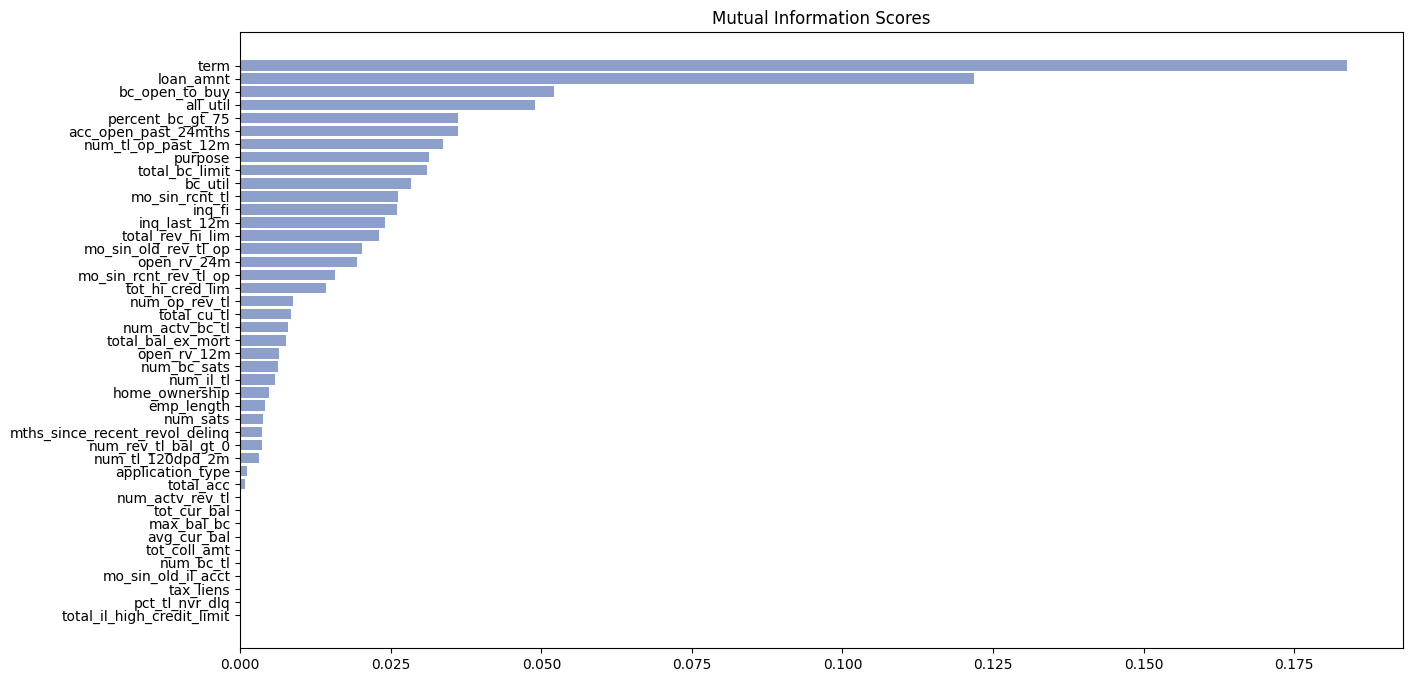

In [34]:
""" Getting mutal information values for numerical values """
mi_scores = helpers.get_and_plot_mi_scores(df_accepted_step2[[col for col in df_accepted_step2.columns if col not in all_common_cols]].copy(),
                                           df_step2_targets, 'grade')

In [35]:
df_accepted_step2 = df_accepted_step2[helpers.get_best_cols_from_mi_scores(mi_scores, df_accepted_step2.copy(), 0.005)]

fico_range_low               0.223728
fico_range_high              0.190964
sec_app_fico_range_high      0.098028
sec_app_fico_range_low       0.090753
verification_status          0.061757
verification_status_joint    0.055169
sec_app_open_acc             0.054598
mort_acc                     0.051641
dti_joint                    0.030320
dti                          0.008460
annual_inc                   0.008226
sec_app_num_rev_accts        0.006524
open_acc                     0.000000
revol_bal                    0.000000
annual_inc_joint             0.000000
sec_app_mort_acc             0.000000
revol_bal_joint              0.000000
num_rev_accts                0.000000
Name: MI Scores, dtype: float64


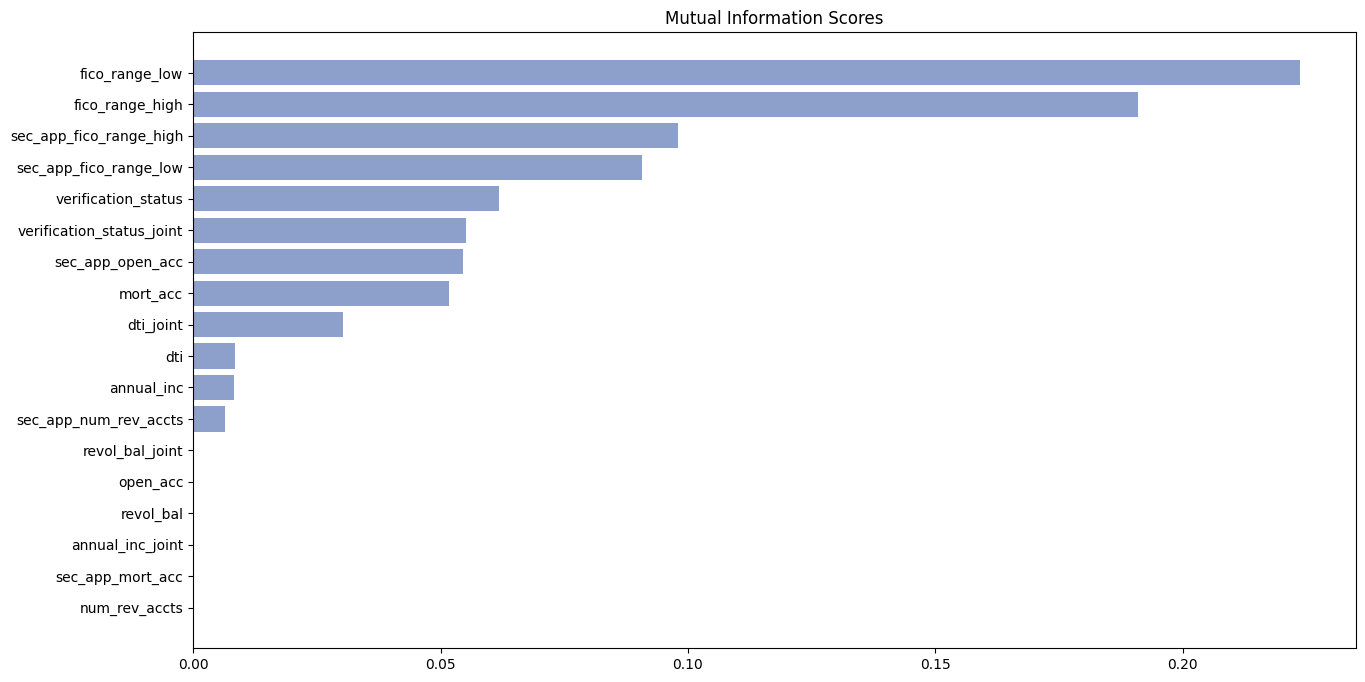

In [36]:
""" Getting mutal information values for numerical values """
mi_scores_joint = helpers.get_and_plot_mi_scores(df_accepted_step2[all_common_cols].copy(),
                                           df_step2_targets, 'grade')

In [37]:
useless_joint_cols = helpers.get_useless_joint_cols(mi_scores_joint, common_not_joint_cols, joint_cols, 0.005)

In [38]:
df_accepted_step2 = df_accepted_step2.drop(useless_joint_cols, axis=1)

In [39]:
to_drop = helpers.get_too_correlated_cols_and_print_pairs(df_accepted_step2, all_common_cols, mi_scores)

In [40]:
df_accepted_step2 = df_accepted_step2.drop(to_drop, axis=1)

In [41]:
if "term" in df_accepted_step2.columns:
    df_accepted_step2['term'] = df_accepted_step2['term'].map({" 36 months": 36, " 60 months": 60})

In [42]:
if "emp_length" in df_accepted_step2.columns:
    df_accepted_step2['emp_length'] = df_accepted_step2['emp_length'].map({"< 1 year": 0, "1 year": 1,
                                                                            "2 years": 2, "3 years": 3,
                                                                            "4 years": 4, "5 years": 5,
                                                                            "6 years": 6, "7 years": 7,
                                                                            "8 years": 8, "9 years": 9, "10+ years":10})

In [43]:
numerical_cols = df_accepted_step2.select_dtypes(include='number').columns.tolist()

## Creating Pipelines - preprocessor, scaling, PCA

In [44]:
joint_cols = set([col for col in df_accepted_step2.columns if "sec" in col or "joint" in col])
joint_num_cols = [col for col in joint_cols if df_accepted_step2[col].dtype != "object"]
joint_cat_cols = [col for col in joint_cols if df_accepted_step2[col].dtype == "object"]

In [45]:
numerical_features = df_accepted_step2.select_dtypes(include=[np.number]).columns.tolist() 
cat_features = df_accepted_step2.select_dtypes(include=['object']).columns.tolist()

In [46]:
num_cols = [col for col in numerical_features if col not in joint_cols]
ord_cols = [col for col in df_accepted_step2.columns if col in ['term', 'emp_length']]
ohec_cols = [col for col in df_accepted_step2.columns if col in cat_features and col not in ord_cols]

In [47]:
df_individual.verification_status_joint.unique()

array([nan], dtype=object)

In [48]:
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split(df_accepted_step2, df_step2_targets,'grade')

In [49]:
preprocessor = helpers.preprocessor(num_cols.copy(), ohec_cols.copy(), ord_cols.copy(), joint_num_cols.copy(), joint_cat_cols.copy())
X_train_transformed = preprocessor.fit_transform(X_train)

Number of components to keep: 34


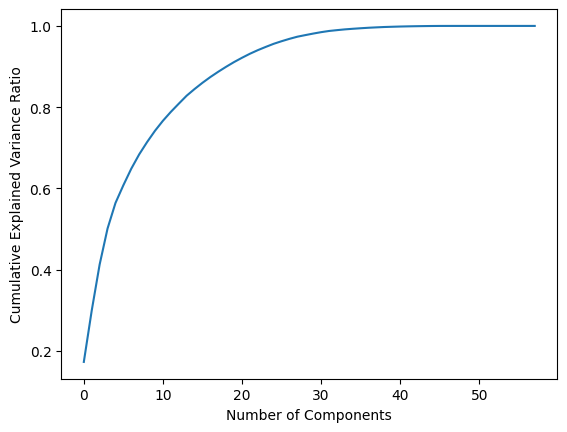

In [50]:
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.99)

In [51]:
df_ipca, ipca= helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.1726138  0.12659178 0.11336933 0.08853989 0.06283792 0.04376578
 0.04076467 0.03524347 0.03033429 0.02779917 0.02459101 0.02190157
 0.0201082  0.01974172 0.0164207  0.01535808 0.0142064  0.01304914
 0.0122799  0.01157526 0.01051626 0.00990628 0.00884524 0.00798538
 0.00760679 0.00638266 0.00587838 0.0052599  0.0039043  0.00376964
 0.00347959 0.00291236 0.00202606 0.0018907 ]


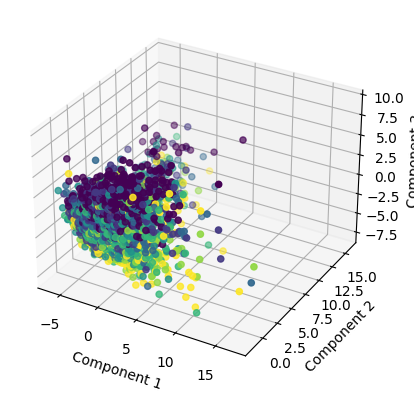

In [52]:
helpers.plot_3_pcas(ipca, X_train_transformed, y_train)

In [53]:
tree_preprocessor = helpers.preprocessor(num_cols.copy(), ohec_cols.copy(), ord_cols.copy(), joint_num_cols.copy(), joint_cat_cols.copy(), 'tree')
X_train_transformed = tree_preprocessor.fit_transform(X_train)

Number of components to keep: 29


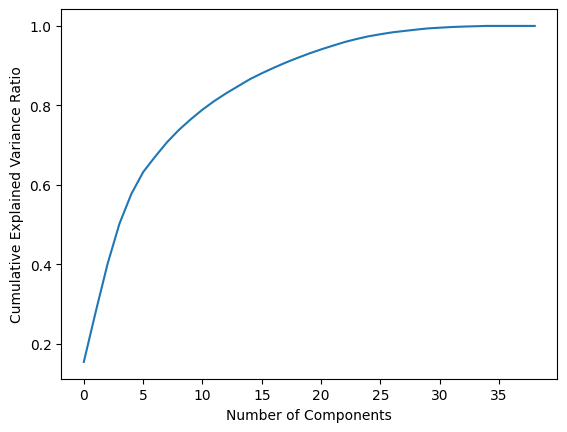

In [54]:
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.99)

In [55]:
df_ipca, tree_ipca= helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.15456673 0.12581897 0.12065773 0.10115259 0.07473264 0.05528137
 0.03852829 0.03622623 0.03103967 0.02676293 0.02462583 0.02174832
 0.01940879 0.01780741 0.01766077 0.01481992 0.01382276 0.01290422
 0.01188828 0.0112457  0.01022416 0.00949669 0.00916771 0.00762072
 0.00670121 0.0052063  0.00468962 0.00338503 0.0032941 ]


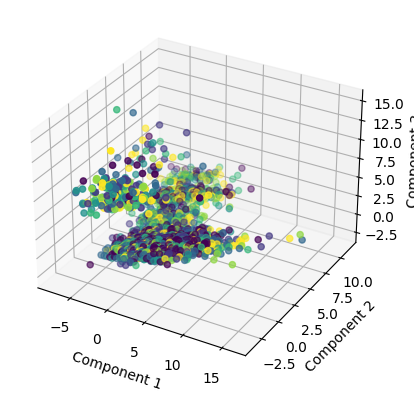

In [56]:
helpers.plot_3_pcas(tree_ipca, X_train_transformed, y_train)

Prediction

In [57]:
tree_models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(), 
    ExtraTreesClassifier(),
    XGBClassifier(),
    lgb.LGBMClassifier(),
    DecisionTreeClassifier()
]

other_models = [
    LogisticRegression(),  
    KNeighborsClassifier(),
    GaussianNB(),
    BernoulliNB(),
    QuadraticDiscriminantAnalysis(),
    PassiveAggressiveClassifier()
]

In [58]:
''' Creating list of pipelines with preprocessor ''' 
pipelines = helpers.getting_pipelines(tree_models, tree_preprocessor, tree_ipca, other_models, preprocessor, ipca)

In [59]:
print("The best performing models are:") 
models_results = helpers.try_models(pipelines, X_train, y_train, X_val, y_val)
models_results.iloc[:, 1:]

The best performing models are:


,model_name,f1_score,recall_score,precision_score
7,LogisticRegression,0.340933,0.352885,0.335507
4,XGBClassifier,0.339949,0.346154,0.336135
5,LGBMClassifier,0.326306,0.332692,0.322274
2,AdaBoostClassifier,0.325425,0.341346,0.320052
0,RandomForestClassifier,0.313135,0.327885,0.307956
3,ExtraTreesClassifier,0.308204,0.326923,0.302690
1,GradientBoostingClassifier,0.302359,0.313462,0.297327
11,QuadraticDiscriminantAnalysis,0.292597,0.308654,0.303840
9,GaussianNB,0.261249,0.276923,0.266438
10,BernoulliNB,0.259662,0.271154,0.257346


In [60]:
results = helpers.optuna_tuning(helpers.objective, models_results.head(3).copy(), X_train, y_train, X_val, y_val)

Tuned LogisticRegression:


,f1_score,penalty,C,solver
0,0.340933,l2,0.005752,liblinear


Tuned XGBClassifier:


,f1_score,max_depth,learning_rate,min_child_weight,subsample,colsample_bytree,gamma,alpha,lambda
0,0.339949,16,0.039225,91,0.174643,0.278398,0.211335,0.475873,0.166925


Tuned LGBMClassifier:


,f1_score,num_leaves,learning_rate,max_depth,min_child_samples,subsample,colsample_bytree
0,0.326306,73,0.030822,5,52,0.250824,0.64953


In [61]:
f1_scores = dict(sorted({model[1]: result['f1_score'] for model, result in results.items()}.items(), key=lambda item: item[1], reverse=True))
f1_scores

{'LogisticRegression': 0.3409332575888822,
 'XGBClassifier': 0.33994850278103583,
 'LGBMClassifier': 0.3263058354750751}

In [62]:
final_model_results = dict(sorted(results.items(), key=lambda item: item[1]['f1_score'], reverse=True))

In [63]:
predictions = helpers.get_top_n_models_preds(final_model_results, X_train, y_train, X_val, 3)

In [64]:
helpers.perform_cross_validation(predictions, X_train, y_train, y_val, score='f1_score') 

------------------------- LogisticRegression -------------------------
TRAIN DATA (cross validated) f1_score is 0.276
VALIDATION DATA - f1_score for the LogisticRegression model is: 0.276

------------------------- XGBClassifier -------------------------
TRAIN DATA (cross validated) f1_score is 0.084
VALIDATION DATA - f1_score for the XGBClassifier model is: 0.183

------------------------ LGBMClassifier ------------------------
TRAIN DATA (cross validated) f1_score is 0.321
VALIDATION DATA - f1_score for the LGBMClassifier model is: 0.32



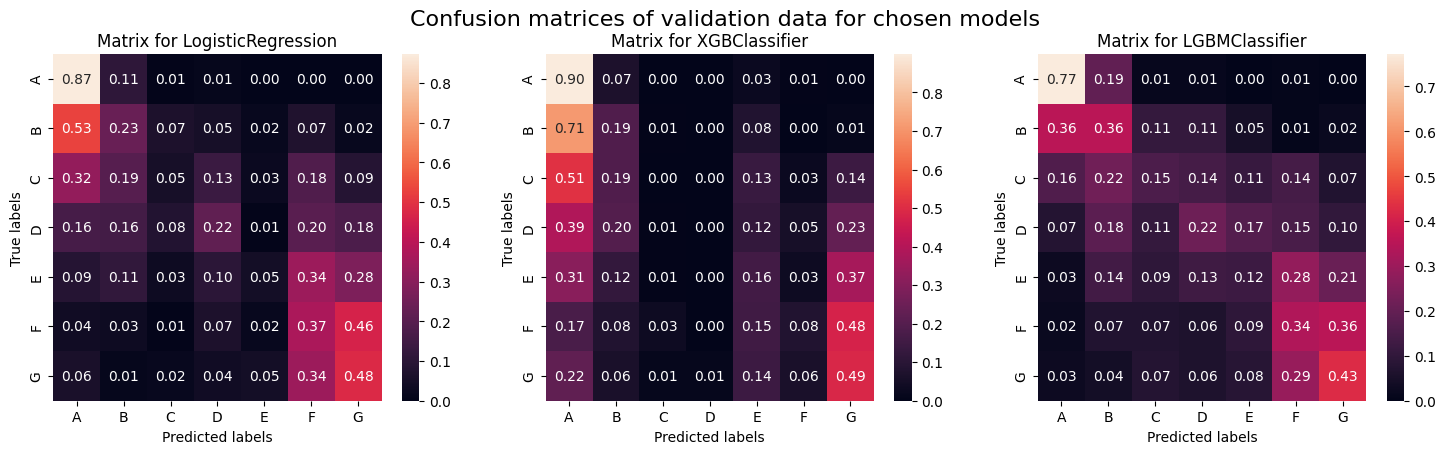

In [65]:
helpers.plot_conf_matrices(predictions, y_val, ["A", "B", "C", "D", "E", "F", "G"])

In [66]:
''' Extracting the best model '''
LOG_model = list(predictions.keys())[1]
preds = LOG_model.predict(X_test)

In [67]:
with open('step2-grade_classifier.pkl', 'wb') as model_file:
    pickle.dump(LOG_model, model_file)

## Step 3

In [68]:
df_accepted_step3 = helpers.stratified_sample(df_accepted, 'sub_grade') 

In [69]:
df_accepted_step3['emp_title'] = df_accepted_step3['emp_title'].str.lower()
df_accepted_step3["emp_title"] = df_accepted_step3['emp_title'].str.replace('[^\w\s]','')

In [70]:
df_accepted_step3 = df_accepted_step3.drop(['emp_title'], axis=1)

In [71]:
df_accepted_step3.sub_grade.value_counts()[:5]

E4    159
G1    159
D1    159
F4    159
A4    159
Name: sub_grade, dtype: int64

In [72]:
df_test = df_accepted_step3.copy()
df_test = helpers.remove_outliers_col(df_test, "loan_amnt", 0.99)
df_test = helpers.remove_outliers_col(df_test, "annual_inc", 0.99)
df_test = helpers.remove_outliers_col(df_test, "dti", 0.99)
df_test = helpers.remove_outliers_col(df_test, "fico_range_low", 0.99)
len(df_test), len(df_accepted_step3)

(4022, 5565)

In [73]:
df_step3_targets = df_accepted_step3[['sub_grade', "int_rate"]]

In [74]:
feature_cols = [col for col in df_accepted_step3.columns if col not in drop_cols]
df_accepted_step3 = df_accepted_step3[[col for col in feature_cols if col not in targets or col == "grade"]]

In [75]:
encoder = LabelEncoder()

In [76]:
encoder.fit(df_accepted_step3['grade'])
df_accepted_step3['grade'] = encoder.transform(df_accepted_step3['grade']) 

In [77]:
encoder.fit(df_step3_targets['sub_grade'])
df_step3_targets['sub_grade'] = encoder.transform(df_step3_targets['sub_grade']) 

In [78]:
joint_cols = list( set([col for col in df_accepted_step3.columns if "sec" in col or "joint" in col]))
common_not_joint_cols = [col for col in df_accepted_step3.columns if not ("sec" in col or "joint" in col) and any(col in joint_col for joint_col in joint_cols)]
all_common_cols = joint_cols + common_not_joint_cols

grade                   1.945910
term                    0.197002
loan_amnt               0.111472
purpose                 0.065839
all_util                0.064357
bc_open_to_buy          0.055368
inq_last_12m            0.054276
num_tl_op_past_12m      0.046736
percent_bc_gt_75        0.041048
total_bc_limit          0.039697
acc_open_past_24mths    0.038248
mo_sin_rcnt_tl          0.032998
inq_fi                  0.032124
emp_length              0.032101
total_rev_hi_lim        0.031858
bc_util                 0.029932
num_bc_sats             0.022452
num_op_rev_tl           0.021636
avg_cur_bal             0.020038
num_bc_tl               0.017170
Name: MI Scores, dtype: float64


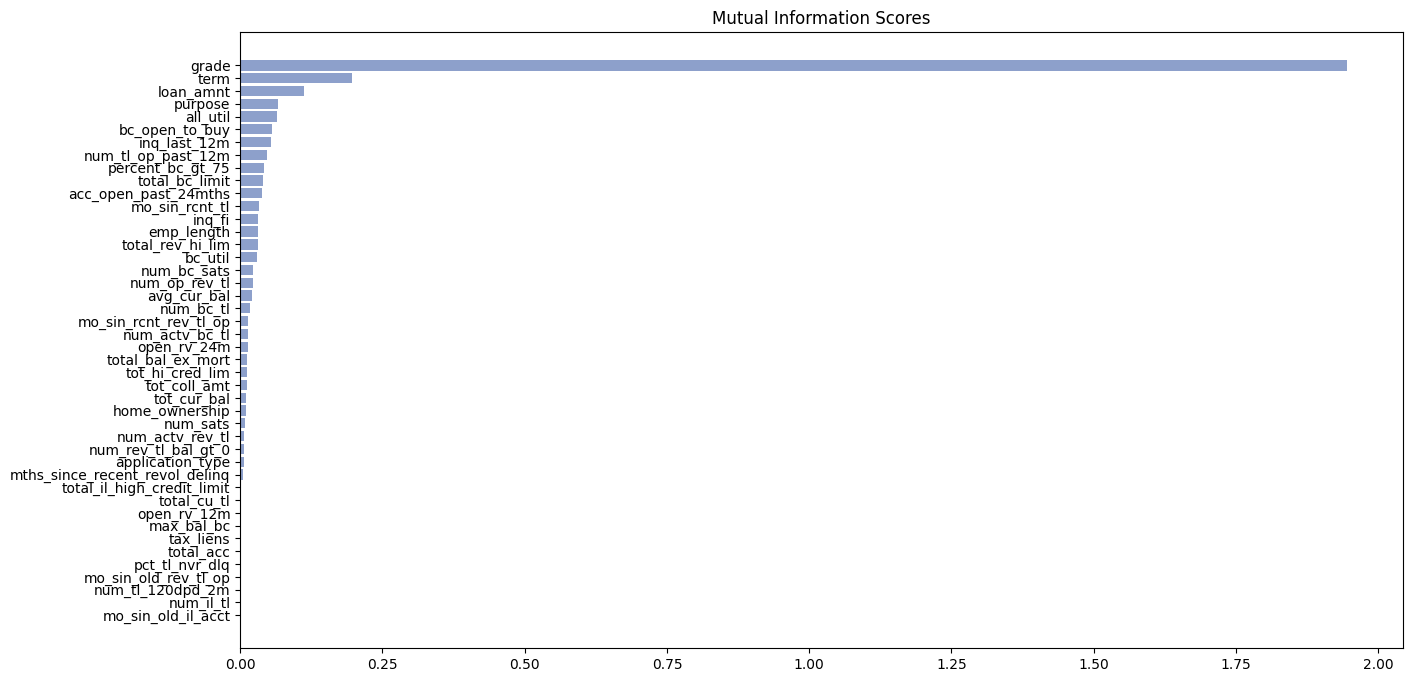

In [79]:
""" Getting mutal information values for numerical values """
mi_scores = helpers.get_and_plot_mi_scores(df_accepted_step3[[col for col in df_accepted_step3.columns if col not in all_common_cols]].copy(),
                                           df_step3_targets, 'sub_grade')

In [80]:
df_accepted_step3 = df_accepted_step3[helpers.get_best_cols_from_mi_scores(mi_scores, df_accepted_step3, 0.1)]

fico_range_high              0.218694
fico_range_low               0.198380
verification_status_joint    0.163863
sec_app_fico_range_high      0.157317
sec_app_fico_range_low       0.149824
verification_status          0.146441
dti_joint                    0.084636
open_acc                     0.037248
revol_bal_joint              0.033205
mort_acc                     0.022498
annual_inc_joint             0.019222
annual_inc                   0.005169
sec_app_mort_acc             0.002604
revol_bal                    0.001625
dti                          0.000000
sec_app_open_acc             0.000000
sec_app_num_rev_accts        0.000000
num_rev_accts                0.000000
Name: MI Scores, dtype: float64


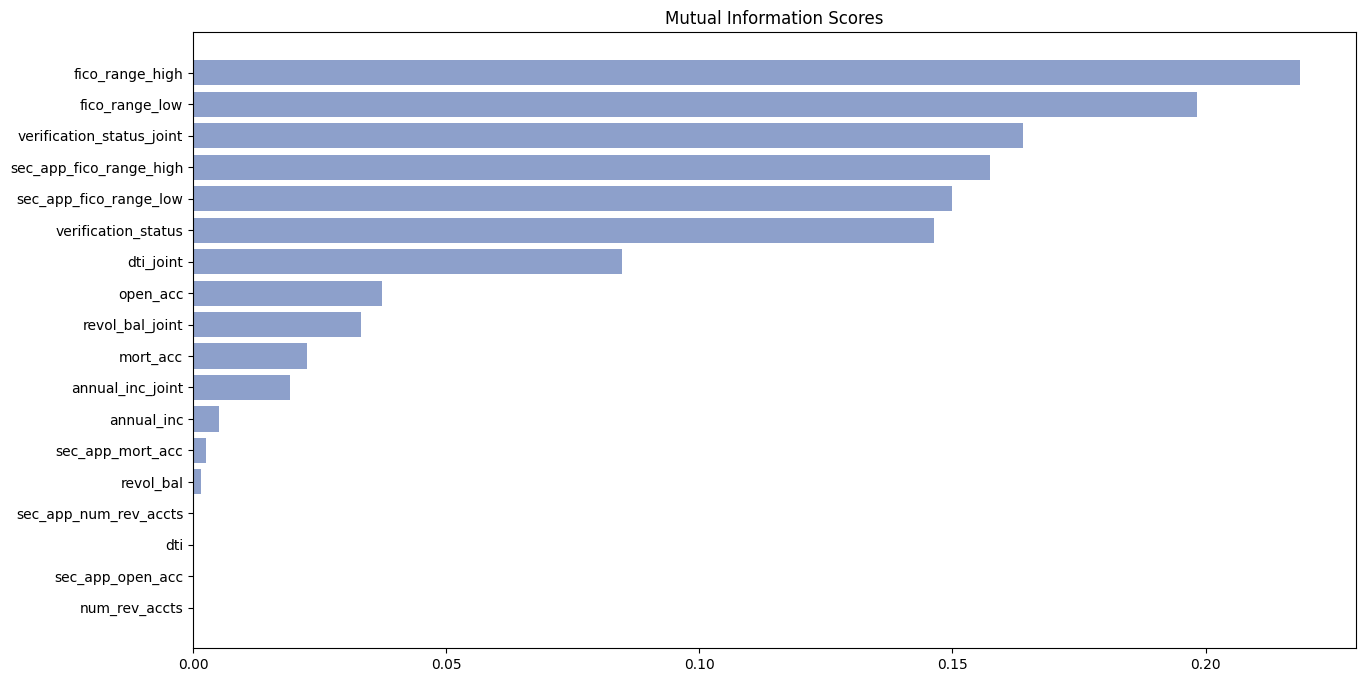

In [81]:
""" Getting mutal information values for numerical values """
joint_mi_scores = helpers.get_and_plot_mi_scores(df_accepted_step3[all_common_cols].copy(),
                                                 df_step3_targets, 'sub_grade')

In [82]:
useless_joint_cols = helpers.get_useless_joint_cols(joint_mi_scores, common_not_joint_cols, joint_cols, 0.1)

In [83]:
df_accepted_step3 = df_accepted_step3.drop(useless_joint_cols, axis=1)

In [84]:
len(df_accepted_step3.columns)

9

In [85]:
if "term" in df_accepted_step3.columns:
    df_accepted_step3['term'] = df_accepted_step3['term'].map({" 36 months": 36, " 60 months": 60})

In [86]:
if "emp_length" in df_accepted_step3.columns:
    df_accepted_step3['emp_length'] = df_accepted_step3['emp_length'].map({"< 1 year": 0, "1 year": 1,
                                                                        "2 years": 2, "3 years": 3,
                                                                        "4 years": 4, "5 years": 5,
                                                                        "6 years": 6, "7 years": 7,
                                                                        "8 years": 8, "9 years": 9, "10+ years":10})

## Creating Pipelines - preprocessor, scaling, PCA

In [87]:
joint_cols = set([col for col in df_accepted_step3.columns if "sec" in col or "joint" in col])
joint_num_cols = [col for col in joint_cols if df_accepted_step3[col].dtype != "object"]
joint_cat_cols = [col for col in joint_cols if df_accepted_step3[col].dtype == "object"]

In [88]:
numerical_features = df_accepted_step3.select_dtypes(include=[np.number]).columns.tolist() 
cat_features = df_accepted_step3.select_dtypes(include=['object']).columns.tolist()

In [89]:
num_cols = [col for col in numerical_features if col not in joint_cols]
ord_cols = [col for col in df_accepted_step3.columns if col in ['term', 'emp_length']]
ohec_cols = [col for col in df_accepted_step3.columns if col in cat_features and col not in ord_cols]

In [90]:
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split(df_accepted_step3, df_step3_targets, 'sub_grade')

In [91]:
preprocessor = helpers.preprocessor(num_cols.copy(), ohec_cols.copy(), ord_cols.copy(), joint_num_cols.copy(), joint_cat_cols.copy())
X_train_transformed = preprocessor.fit_transform(X_train)

Number of components to keep: 7


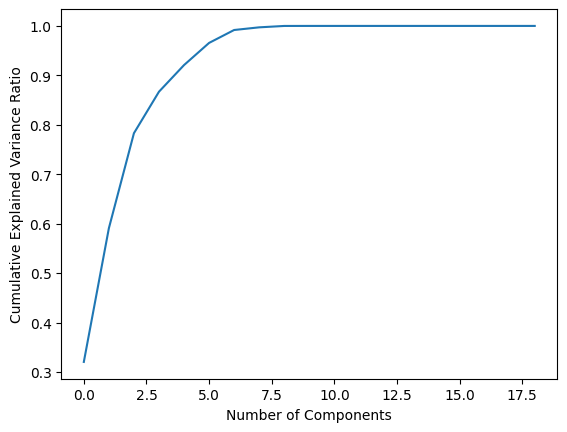

In [92]:
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.99)

In [93]:
df_ipca, ipca= helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.32026138 0.27045891 0.19220747 0.08397268 0.05387826 0.04483189
 0.02613496]


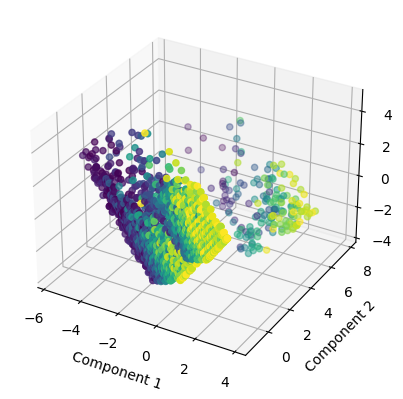

In [94]:
helpers.plot_3_pcas(ipca, X_train_transformed, y_train)

In [95]:
tree_preprocessor = helpers.preprocessor(num_cols.copy(), ohec_cols.copy(), ord_cols.copy(), joint_num_cols.copy(), joint_cat_cols.copy(), 'tree')
X_train_transformed = tree_preprocessor.fit_transform(X_train)

Number of components to keep: 6


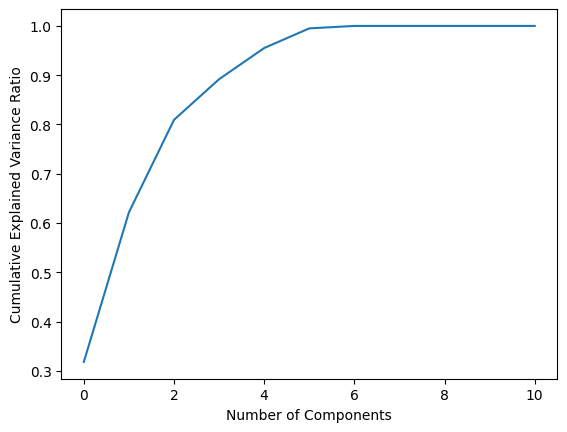

In [96]:
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.99)

In [97]:
df_ipca, tree_ipca = helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.31818836 0.30352961 0.18772221 0.08243956 0.0632512  0.03987089]


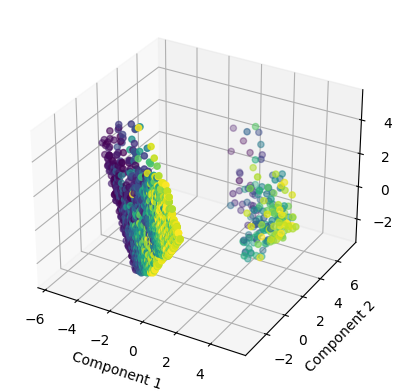

In [98]:
helpers.plot_3_pcas(tree_ipca, X_train_transformed, y_train)

## Sub grade prediction

In [99]:
''' Creating list of pipelines with preprocessor ''' 
pipelines = helpers.getting_pipelines(tree_models, tree_preprocessor, tree_ipca, other_models, preprocessor, ipca)

In [100]:
print("The best performing models are:") 
models_results = helpers.try_models(pipelines, X_train, y_train, X_val, y_val)
models_results.iloc[:, 1:]

The best performing models are:


,model_name,f1_score,recall_score,precision_score
3,ExtraTreesClassifier,0.208057,0.210526,0.211122
0,RandomForestClassifier,0.202607,0.205392,0.204929
5,LGBMClassifier,0.201653,0.204108,0.206076
4,XGBClassifier,0.200772,0.202824,0.203666
1,GradientBoostingClassifier,0.190561,0.195122,0.192982
7,LogisticRegression,0.186926,0.207959,0.195823
6,DecisionTreeClassifier,0.183272,0.186136,0.185975
8,KNeighborsClassifier,0.146576,0.151476,0.147446
11,QuadraticDiscriminantAnalysis,0.139465,0.219512,0.212657
9,GaussianNB,0.091501,0.118100,0.107533


In [101]:
results = helpers.optuna_tuning(helpers.objective, models_results.head(3).copy(), X_train, y_train, X_val, y_val)

Tuned ExtraTreesClassifier:


,f1_score,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features
0,0.206884,994,7,45,3,0.143585


Tuned RandomForestClassifier:


,f1_score,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features
0,0.215081,307,2,35,14,0.10649


Tuned LGBMClassifier:


,f1_score,num_leaves,learning_rate,max_depth,min_child_samples,subsample,colsample_bytree
0,0.201653,234,0.510173,7,77,0.191964,0.49585


In [102]:
f1_scores = dict(sorted({model[1]: result['f1_score'] for model, result in results.items()}.items(), key=lambda item: item[1], reverse=True))
f1_scores

{'RandomForestClassifier': 0.2150811289157824,
 'ExtraTreesClassifier': 0.206884098441676,
 'LGBMClassifier': 0.20165267956426994}

In [103]:
final_model_results = dict(sorted(results.items(), key=lambda item: item[1]['f1_score'], reverse=True))

In [104]:
predictions = helpers.get_top_n_models_preds(final_model_results, X_train, y_train, X_val, 3)

In [105]:
helpers.perform_cross_validation(predictions, X_train, y_train, y_val, score='f1_score') 

------------------------ RandomForestClassifier ------------------------
TRAIN DATA (cross validated) f1_score is 0.091
VALIDATION DATA - f1_score for the RandomForestClassifier model is: 0.07

------------------------- ExtraTreesClassifier -------------------------
TRAIN DATA (cross validated) f1_score is 0.144
VALIDATION DATA - f1_score for the ExtraTreesClassifier model is: 0.152

------------------------- LGBMClassifier -------------------------
TRAIN DATA (cross validated) f1_score is 0.186
VALIDATION DATA - f1_score for the LGBMClassifier model is: 0.197



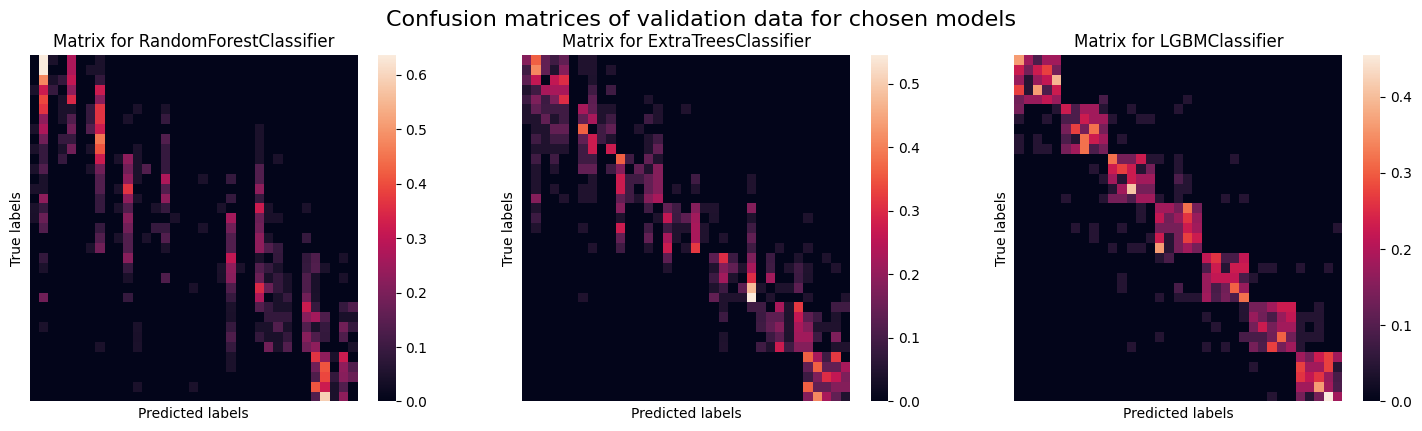

In [106]:
helpers.plot_conf_matrices(predictions, y_val, annot=False)

In [107]:
''' Extracting the best model '''
LOG_model = list(predictions.keys())[0]
preds = LOG_model.predict(X_test)

In [108]:
with open('step3-subgrade_classifier.pkl', 'wb') as model_file:
    pickle.dump(LOG_model, model_file)